In [1]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.colors import LogNorm
import uproot_methods
from tqdm.auto import tqdm
import time
import re

from utils import (
    set_plotting_style, get_chunking, make_df, hist2d_dask, query_dis,
    dataframe_to_ttree, ttree_to_dataframe
)
import utils

from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
from dask import delayed
from yahist import Hist1D, Hist2D

from daskucsd.condor_utils import make_htcondor_cluster

from utils import hacky_query_eval as hqe
import subprocess
import json
import requests
import re

In [2]:
set_plotting_style()

In [3]:
remake = False
if remake:
    from dask.distributed import LocalCluster
    localcluster = LocalCluster(n_workers=10, threads_per_worker=1, memory_limit="4GB")
    localcluster

In [22]:
if remake:
    client = Client(localcluster)

In [6]:
fnames_data = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run201*skim_201*_v12_RAW_v24/*.root")
len(fnames_data)

342

In [24]:
if remake:
    fname = fnames_data[:]
    # branches = ["pass_baseline_iso", "pass_materialveto", "lxy", "DV_x", "DV_y"]
    branches = ["DV_x", "DV_y","DV_z","pass_l1","pass_materialveto","pass_baseline_iso"]
    cut = "pass_l1"
    # branches = ["pass_baseline_iso", "logabsetaphi", "pass_excesshits", "lxy", "DV_distPixel"]
    # cut = "pass_baseline_iso and logabsetaphi<1.25 and pass_excesshits and lxy > 0"
    df_data = make_df(fname, branches=branches, cut=cut, use_dask=True, client=client)

In [25]:
if remake:
    from dask.distributed import progress
    progress(df_data)

VBox()

In [26]:
if remake:
    df_data = df_data.compute()
    utils.dataframe_to_ttree(df_data, "data_matveto_pass_l1.root")

In [15]:
def add_cms_info_1d(ax, typ="Preliminary", lumi="10.1", xtype=0.105):
    ax.text(0.0, 1.01,"CMS", horizontalalignment='left', verticalalignment='bottom', transform = ax.transAxes, name="Arial", weight="bold", size=14)
    ax.text(xtype, 1.01,"Preliminary", horizontalalignment='left', verticalalignment='bottom', transform = ax.transAxes, name="Arial", style="italic", size=13)
    ax.text(0.99, 1.01,"%s fb${}^\mathregular{-1}$ (13 TeV)" % (lumi), horizontalalignment='right', verticalalignment='bottom', transform = ax.transAxes, size=12)

def add_cms_info_2d(ax, typ="Preliminary", lumi="10.1", xtype=0.15):
    ax.text(0.0, 1.01,"CMS", horizontalalignment='left', verticalalignment='bottom', transform = ax.transAxes, name="Arial", weight="bold", size=14)
    ax.text(xtype, 1.01,"Preliminary", horizontalalignment='left', verticalalignment='bottom', transform = ax.transAxes, name="Arial", style="italic", size=13)
    ax.text(0.99, 1.01,"%s fb${}^\mathregular{-1}$ (13 TeV)" % (lumi), horizontalalignment='right', verticalalignment='bottom', transform = ax.transAxes, size=12)
#     ax.text(0.99, 1.01,"(13 TeV)", horizontalalignment='right', verticalalignment='bottom', transform = ax.transAxes, size=12)

### DV y vs x, and rho vs z before and after material veto
Selection is just passing L1

In [3]:
fname = "data_matveto_pass_l1.root"
branches = ["DV_x", "DV_y","DV_z","pass_l1","pass_materialveto","pass_baseline_iso"]
df_data = ttree_to_dataframe(fname,  branches=branches)

df_data["DV_rho"] = df_data.eval("(DV_x**2+DV_y**2)**0.5")

In [30]:
def chunker(seq, size=20e6):
    size = int(size)
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

h_tot_all = None
h_tot_pass = None

cols, bins_x, bins_y = ["DV_x","DV_y"], np.linspace(-11,11,300), np.linspace(-11,11,300)
# cols, bins_x, bins_y = ["DV_z","DV_rho"], np.linspace(-40,40,150), np.linspace(0,11,150)

for i,df in tqdm(enumerate(chunker(df_data))):
#     h_all = Hist2D(df[cols], bins=bins)
#     h_pass = Hist2D(df[df["pass_materialveto"]][cols], bins=bins)
    
    m = df[cols].values
    counts, edges_x, edges_y = utils.numba_histogram2d(m[:,0], m[:,1], bins_x, bins_y)
    h_all = Hist2D.from_bincounts(counts.T, [edges_x, edges_y])
    
    m = df[cols][df["pass_materialveto"]].values
    counts, edges_x, edges_y = utils.numba_histogram2d(m[:,0], m[:,1], bins_x, bins_y)
    h_pass = Hist2D.from_bincounts(counts.T, [edges_x, edges_y])

    if h_tot_all is None:
        h_tot_all = h_all
        h_tot_pass = h_pass
    else:
        h_tot_all += h_all
        h_tot_pass += h_pass
h_tot_all

[[ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   ...    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   ...    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   ...    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 ...
 [ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   ...    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   ...    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   ...    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]]

/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


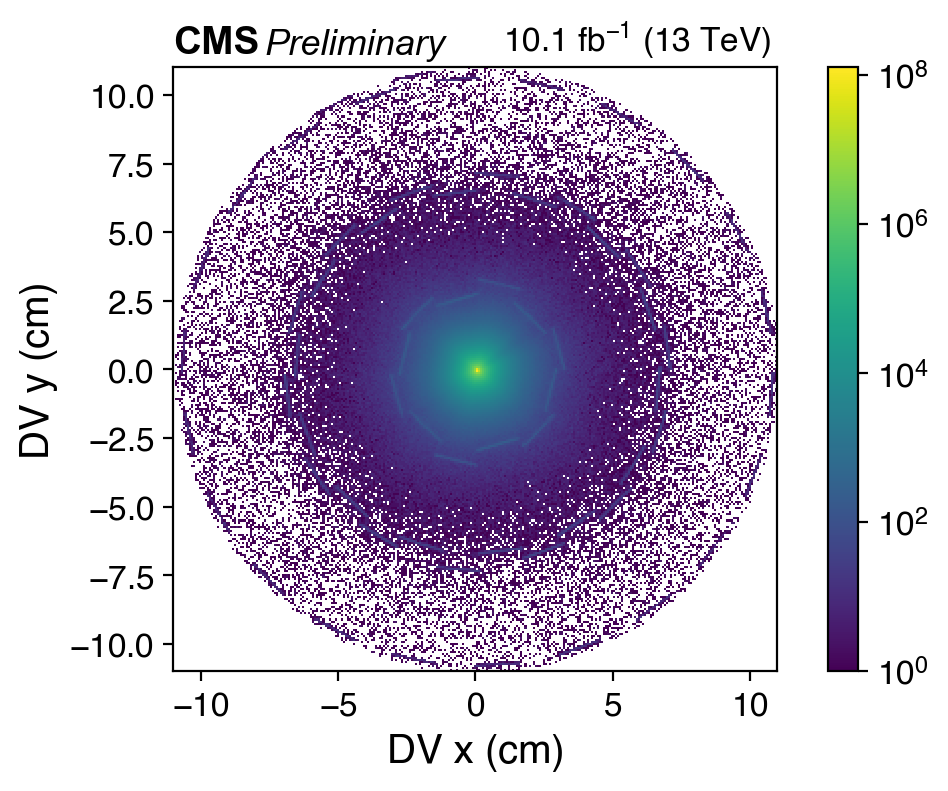

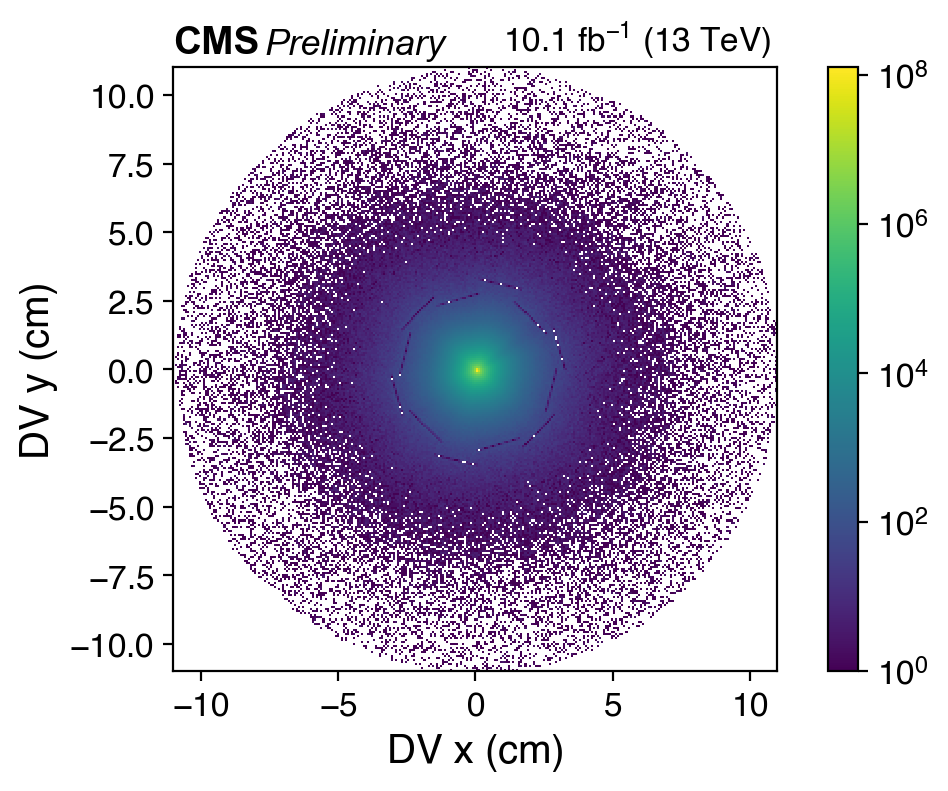

In [32]:
!mkdir -p plots_selection/

saxis, xlabel, ylabel = "xy", "DV x (cm)", "DV y (cm)"
# saxis, xlabel, ylabel = "rhoz", "DV z (cm)", "DV rho (cm)"

for which in ["all", "pass"]:
    fig, ax = plt.subplots()
    if which == "pass":
        h = h_tot_pass
    else:
        h = h_tot_all
    h.plot(logz=True, cmap="viridis", )

    add_cms_info_2d(ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_aspect({"rhoz": 2.5, "xy": 1.0}[saxis])

    fig.savefig(f"plots_selection/passL1_DV_{saxis}_{which}.pdf")

In [115]:
h_tot_all = None
h_tot_pass = None

cols, bins = "DV_rho", np.linspace(0,11,100)

h_tot_all = Hist1D(df_data[cols], bins=bins, overflow=False)
h_tot_pass = Hist1D(df_data[cols][df_data["pass_materialveto"]], bins=bins, overflow=False)

h_tot_all

[141385558.00 ± 11890.57   139515533.00 ± 11811.67   24931205.00 ± 4993.12
 13076710.00 ± 3616.17   7473434.00 ± 2733.76   4506870.00 ± 2122.94
 2835478.00 ± 1683.89   1853813.00 ± 1361.55   1249295.00 ± 1117.72
 866159.00 ± 930.68   614309.00 ± 783.78   447663.00 ± 669.08
 330320.00 ± 574.73   248618.00 ± 498.62   189809.00 ± 435.67
 146536.00 ± 382.80   115518.00 ± 339.88   92235.00 ± 303.70
 73634.00 ± 271.36   59758.00 ± 244.45   48538.00 ± 220.31
 40207.00 ± 200.52   33685.00 ± 183.53   32910.00 ± 181.41
 29007.00 ± 170.31   26726.00 ± 163.48   23125.00 ± 152.07
 17109.00 ± 130.80   16344.00 ± 127.84   14251.00 ± 119.38
 11412.00 ± 106.83   8947.00 ± 94.59   7565.00 ± 86.98   6835.00 ± 82.67
 6016.00 ± 77.56   5610.00 ± 74.90   5061.00 ± 71.14   4595.00 ± 67.79
 4236.00 ± 65.08   3912.00 ± 62.55   3554.00 ± 59.62   3413.00 ± 58.42
 3077.00 ± 55.47   2874.00 ± 53.61   2747.00 ± 52.41   2521.00 ± 50.21
 2453.00 ± 49.53   2259.00 ± 47.53   2142.00 ± 46.28   1978.00 ± 44.47
 1950.00 ± 44.16   1873.00 ± 43.28   1698.00 ± 41.21   1690.00 ± 41.11
 1614.00 ± 40.17   1551.00 ± 39.38   1397.00 ± 37.38   2121.00 ± 46.05
 3876.00 ± 62.26   4252.00 ± 65.21   5059.00 ± 71.13   3121.00 ± 55.87
 3317.00 ± 57.59   4396.00 ± 66.30   1969.00 ± 44.37   1220.00 ± 34.93
 1048.00 ± 32.37   822.00 ± 28.67   752.00 ± 27.42   732.00 ± 27.06
 694.00 ± 26.34   716.00 ± 26.76   626.00 ± 25.02   695.00 ± 26.36
 633.00 ± 25.16   640.00 ± 25.30   650.00 ± 25.50   598.00 ± 24.45
 635.00 ± 25.20   656.00 ± 25.61   698.00 ± 26.42   603.00 ± 24.56
 513.00 ± 22.65   555.00 ± 23.56   532.00 ± 23.07   555.00 ± 23.56
 638.00 ± 25.26   620.00 ± 24.90   581.00 ± 24.10   568.00 ± 23.83
 580.00 ± 24.08   585.00 ± 24.19   541.00 ± 23.26   525.00 ± 22.91
 580.00 ± 24.08   1924.00 ± 43.86   1857.00 ± 43.09   2806.00 ± 52.97
 677.00 ± 26.02]

data_passL1_lxy_materialveto.pdf


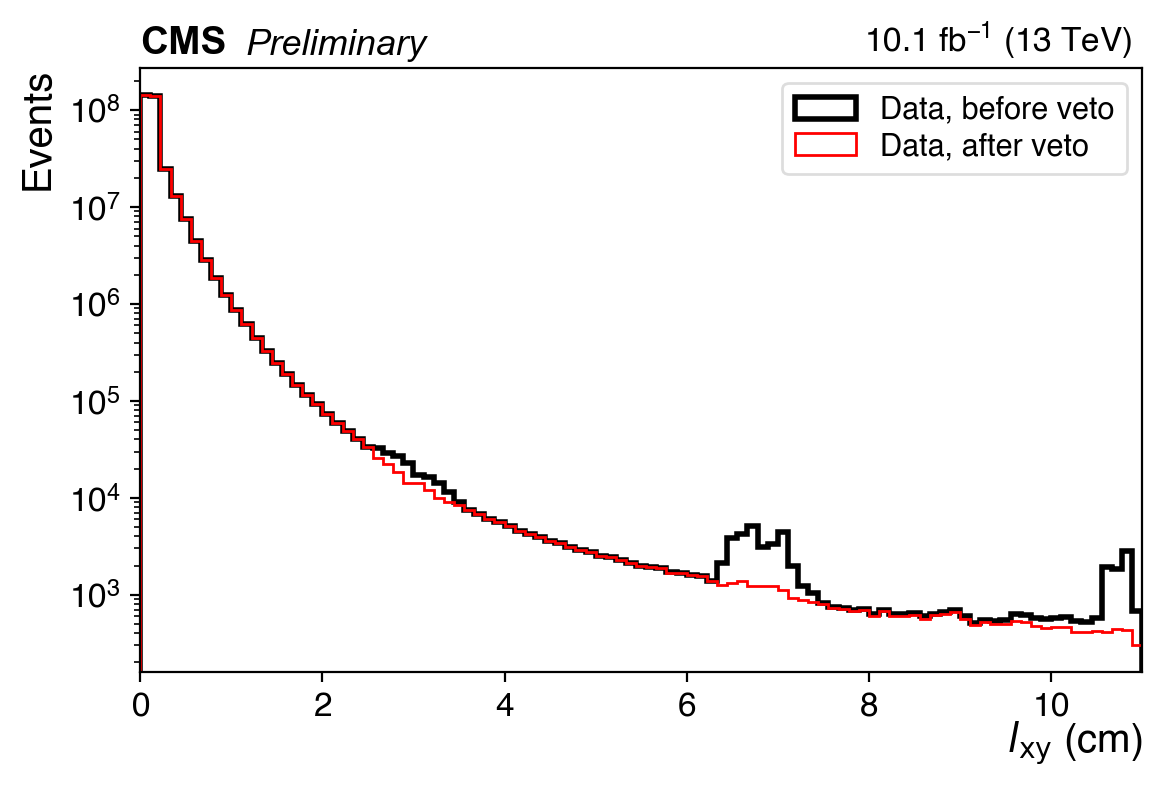

In [116]:
!mkdir -p plots_selection/

fig, ax = plt.subplots()

label = "Data"
h_tot_all.plot(color="k", label=label + ", before veto", histtype="step", lw=2.0)
h_tot_pass.plot(color="r", label=label + f", after veto", histtype="step", lw=1.0)

# ax.set_ylim(bottom=0.)
ax.set_yscale("log")

add_cms_info_1d(ax)
ax.set_ylabel("Events", horizontalalignment="right",y=1.)
xlabel = r"$l_\mathrm{xy}$ (cm)"
ax.set_xlabel(xlabel, horizontalalignment="right",x=1., labelpad=-1.0)

fname = f"data_passL1_lxy_materialveto.pdf"
print(fname)
fig.savefig(f"plots_selection/{fname}")

### plot of lxy before and after in simulation, along with rough efficiency drop for the material veto
Selection is just passing L1

In [57]:
model_info = {
#     ("bphi",0.5,1): dict(label=r"B$\rightarrow\phi$ (0.5GeV,c$\tau$=1mm)", color=[0.98,0.85,0.29]),
#     ("bphi",2,10): dict(label=r"B$\rightarrow\phi$ (2GeV,c$\tau$=10mm)", color=[0.94,0.58,0.21]),
#     ("bphi",4,100):  dict(label=r"B$\rightarrow\phi$ (4GeV,c$\tau$=100mm)", color=[0.92,0.28,0.15]),
#     ("hzd",2,100): dict(label=r"H$\rightarrow \mathrm{Z_d Z_d}$ (2GeV,c$\tau$=100mm)", color=[0.46,0.98,0.73]),
    ("hzd",8,10): dict(label=r"H$\rightarrow \mathrm{Z_d Z_d}$ (8GeV,c$\tau$=10mm)", color=[0.33,0.73,0.98]),
#     ("hzd",15,1): dict(label=r"H$\rightarrow \mathrm{Z_d Z_d}$ (15GeV,c$\tau$=1mm)", color=[0.53,0.10,0.96]),
}

dfs_mc = dict()
for key in tqdm(model_info.keys()):
    model, mass, ctau = key
    smodel = {"bphi":"BToPhi","hzd":"HToZdZd"}[model]
    particle = {"bphi":"mphi","hzd":"mzd"}[model]
    smass = str(mass).replace(".0","").replace(".","p")
    fpatt = f"/hadoop/cms/store/user/namin/ProjectMetis/{smodel}*_*{particle}{smass}_ctau{ctau}mm_BABY_vtestfine2/*.root"
    fnames = glob.glob(fpatt)
    def df_from_one_file(fname):
        t = uproot.open(fname)["Events"]
        branches = ["pass_l1", "pass_materialveto", "lxy", "dimuon_mass"]
        df = pd.DataFrame(t.arrays(branches, namedecode="ascii"))
        df = df[df.eval("pass_l1")]
        return df
    df = pd.concat(map(df_from_one_file,fnames)).reset_index(drop=True)
    dfs_mc[key] = df

signal_passL1_lxy_materialveto.pdf


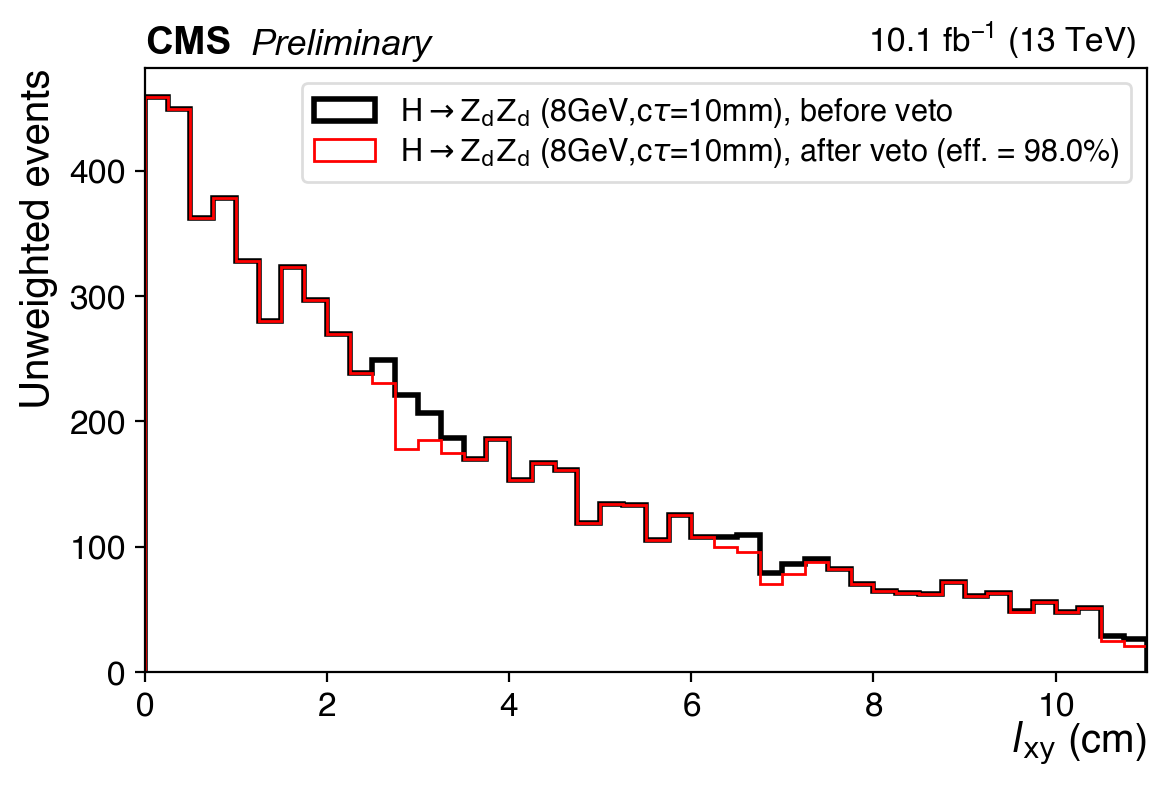

In [69]:
!mkdir -p plots_selection/

def get_vals(df, varexp, massrange, lxyrange):
    masslow, masshigh = massrange
    lxylow, lxyhigh = lxyrange
    if masslow == None: masslow = 0.
    if masshigh == None: masshigh = 999.
    v1 = df[df.eval(f"{masslow}<dimuon_mass<{masshigh} and {lxylow}<lxy<{lxyhigh}")].eval(varexp)
    v2 = df[df.eval(f"{masslow}<dimuon_mass<{masshigh} and {lxylow}<lxy<{lxyhigh} and pass_materialveto")].eval(varexp)
    return v1, v2

for varexp in ["lxy"]:
    fig, ax = plt.subplots()

    bins = {
        "lxy": "44,0,11",
    }[varexp]

    lxyrange = [0, 11.]
    for key,df in dfs_mc.items():
        v1, v2 = get_vals(df, varexp, [None, None], lxyrange)
        h1 = Hist1D(v1, bins=bins)
        h2 = Hist1D(v2, bins=bins)
        color = model_info[key]["color"]
        label = model_info[key]["label"]
        h1.plot(color="k", label=label + ", before veto", histtype="step", lw=2.0)
        eff = h2.integral/h1.integral
        h2.plot(color="r", label=label + f", after veto (eff. = {eff*100:.1f}%)", histtype="step", lw=1.0)

    ax.set_ylim(bottom=0.)

    add_cms_info_1d(ax)
    ax.set_ylabel("Unweighted events", horizontalalignment="right",y=1.)
    xlabel = {
        "lxy": r"$l_\mathrm{xy}$ (cm)",
    }[varexp]
    ax.set_xlabel(xlabel, horizontalalignment="right",x=1., labelpad=-1.0)

    fname = f"signal_passL1_lxy_materialveto.pdf"
    print(fname)
    fig.savefig(f"plots_selection/{fname}")
#     plt.close()

### plot of various dxy quantities in data and MC
Selection is passing all cuts except the two dxy related ones

In [11]:
fname = "data_unblind10ifb_nodxyerrcut.root"
branches = [
    "pass_baseline_extra_iso",
    "logabsetaphi",
    "Muon1_dxyError",
    "Muon1_dxyCorr",
    "Muon2_dxyError",
    "Muon2_dxyCorr",
    "dimuon_pt",
    "dimuon_mass",
    "lxy",
]
df_data = ttree_to_dataframe(fname,  branches=branches)
df_data = df_data[df_data.eval("pass_baseline_extra_iso and logabsetaphi<1.25")]

def augment_df(df):
    df["mindxysignificance"] = np.minimum(
        df.eval("abs(Muon1_dxyCorr/Muon1_dxyError)"),
        df.eval("abs(Muon2_dxyCorr/Muon2_dxyError)"),
    )
    df["minscaleddxy"] = np.minimum(
        df.eval("abs(Muon1_dxyCorr)/(lxy*dimuon_mass/dimuon_pt)"),
        df.eval("abs(Muon2_dxyCorr)/(lxy*dimuon_mass/dimuon_pt)"),
    )
    df["minabsdxy"] = np.minimum(
        df.eval("abs(Muon1_dxyCorr)"),
        df.eval("abs(Muon2_dxyCorr)"),
    )
    return df

df_data = augment_df(df_data)

In [12]:
print(df_data.memory_usage().sum()*1e-6)
print(len(df_data))
df_data

622.3971789999999
11743343


,Muon1_dxyCorr,Muon1_dxyError,Muon2_dxyCorr,Muon2_dxyError,dimuon_mass,dimuon_pt,logabsetaphi,lxy,pass_baseline_extra_iso,mindxysignificance,minscaleddxy,minabsdxy
0,-0.044357,0.003882,0.056791,0.003661,2.850667,13.741179,-0.030916,0.337501,True,11.425678,0.633527,0.044357
1,0.043461,0.006017,-0.050502,0.005914,1.848771,6.603384,-2.220810,0.174900,True,7.223384,0.887549,0.043461
2,0.033959,0.004005,-0.066221,0.004389,3.140836,17.366030,-0.020314,0.376856,True,8.480082,0.498238,0.033959
3,-0.018732,0.004492,0.007575,0.006338,2.673129,12.651072,0.776609,0.377663,True,1.195155,0.094931,0.007575
4,-0.017455,0.003271,0.024900,0.004909,2.639816,18.655199,0.185471,0.269190,True,5.072110,0.458242,0.017455
...,...,...,...,...,...,...,...,...,...,...,...,...
11743338,-0.005103,0.002523,0.010032,0.005812,3.657936,11.097305,0.373630,0.059507,True,1.726094,0.260164,0.005103
11743339,0.000714,0.002711,-0.000586,0.003107,0.671139,12.202892,-0.094017,0.015691,True,0.188459,0.678523,0.000586
11743340,-0.033248,0.007240,0.042309,0.003544,3.065516,9.839929,-0.192205,0.148931,True,4.592330,0.716596,0.033248
11743341,-0.019105,0.003374,0.023935,0.002643,1.958615,9.371922,-0.309720,0.116969,True,5.662821,0.781565,0.019105


In [13]:
model_info = {
    ("bphi",0.5,1): dict(label=r"B$\rightarrow\phi$ (0.5GeV,c$\tau$=1mm)", color=[0.98,0.85,0.29]),
    ("bphi",2,10): dict(label=r"B$\rightarrow\phi$ (2GeV,c$\tau$=10mm)", color=[0.94,0.58,0.21]),
    ("bphi",4,100):  dict(label=r"B$\rightarrow\phi$ (4GeV,c$\tau$=100mm)", color=[0.92,0.28,0.15]),
    ("hzd",2,100): dict(label=r"H$\rightarrow \mathrm{Z_d Z_d}$ (2GeV,c$\tau$=100mm)", color=[0.46,0.98,0.73]),
    ("hzd",8,10): dict(label=r"H$\rightarrow \mathrm{Z_d Z_d}$ (8GeV,c$\tau$=10mm)", color=[0.33,0.73,0.98]),
    ("hzd",15,1): dict(label=r"H$\rightarrow \mathrm{Z_d Z_d}$ (15GeV,c$\tau$=1mm)", color=[0.53,0.10,0.96]),
}

dfs_mc = dict()
for key in tqdm(model_info.keys()):
    model, mass, ctau = key
    smodel = {"bphi":"BToPhi","hzd":"HToZdZd"}[model]
    particle = {"bphi":"mphi","hzd":"mzd"}[model]
    smass = str(mass).replace(".0","").replace(".","p")
    fpatt = f"/hadoop/cms/store/user/namin/ProjectMetis/{smodel}*_*{particle}{smass}_ctau{ctau}mm_BABY_vtestfine2/*.root"
    fnames = glob.glob(fpatt)
    def df_from_one_file(fname):
        t = uproot.open(fname)["Events"]
        df = pd.DataFrame(t.arrays(branches, namedecode="ascii"))
        df["mindxysignificance"] = np.minimum(
            df.eval("abs(Muon1_dxyCorr/Muon1_dxyError)"),
            df.eval("abs(Muon2_dxyCorr/Muon2_dxyError)"),
        )
        df["minscaleddxy"] = np.minimum(
            df.eval("abs(Muon1_dxyCorr)/(lxy*dimuon_mass/dimuon_pt)"),
            df.eval("abs(Muon2_dxyCorr)/(lxy*dimuon_mass/dimuon_pt)"),
        )
        df["minabsdxy"] = np.minimum(
            df.eval("abs(Muon1_dxyCorr)"),
            df.eval("abs(Muon2_dxyCorr)"),
        )
        df = df[df.eval("pass_baseline_extra_iso and logabsetaphi<1.25")]
        return df
    df = pd.concat(map(df_from_one_file,fnames)).reset_index(drop=True)
    dfs_mc[key] = df

In [21]:
!mkdir -p plots_selection/

def get_vals(df, varexp, massrange, lxyrange):
    masslow, masshigh = massrange
    lxylow, lxyhigh = lxyrange
    if masslow == None: masslow = 0.
    if masshigh == None: masshigh = 999.
    return df[df.eval(f"{masslow}<dimuon_mass<{masshigh} and {lxylow}<lxy<{lxyhigh}")].eval(varexp)

for varexp in ["minscaleddxy", "mindxysignificance", "minabsdxy"]:
# for varexp in ["minabsdxy"]:
    for lxyrange in [
        [0.0, 0.2],
        [0.2, 1.0],
        [1.0, 11.0],
    ]:
        fig, ax = plt.subplots()

        bins = {
            "minscaleddxy": "40,0,1",
            "mindxysignificance": "40,0,20",
            "minabsdxy": "50,0,1",
        }[varexp]


        h = Hist1D(get_vals(df_data, varexp, [None, 5], lxyrange), bins=bins).normalize()
        h.plot(show_errors=True, color="k", label="Data (mass < 5 GeV)", markersize=3.5)

        h = Hist1D(get_vals(df_data, varexp, [5, None], lxyrange), bins=bins).normalize()
        h.plot(show_errors=True, color="b", label="Data (mass > 5 GeV)", markersize=3.5)

        for key,df in dfs_mc.items():
            h = Hist1D(get_vals(df, varexp, [None, None], lxyrange), bins=bins).normalize()
            color = model_info[key]["color"]
            label = model_info[key]["label"]
            h.plot(color=color, label=label, histtype="step")

        if varexp in ["minabsdxy"]:
            ax.set_yscale("log")
        else:
            ax.set_ylim(bottom=0.)

        add_cms_info_1d(ax)
        ax.set_ylabel("Fraction of events", horizontalalignment="right",y=1.)
        xlabel = {
            "minscaleddxy": r"minimum lifetime-scaled |$d_\mathrm{xy}$|",
            "minabsdxy": r"minimum |$d_\mathrm{xy}$|",
            "mindxysignificance": r"minimum $d_\mathrm{xy}$ significance",
        }[varexp]
        ax.set_xlabel(xlabel, horizontalalignment="right",x=1., labelpad=-1.0)

        vline = {
            "minscaleddxy": 0.1,
            "mindxysignificance": 2,
        }.get(varexp, None)
        if vline is not None:
            ax.axvline(vline, color="red", linestyle="--")

        ax.set_title(f"{lxyrange[0]} cm < $l_\mathrm{{xy}}$ < {lxyrange[1]} cm", color=(0.22,0.62,0.13))
        

        slxy0 = str(lxyrange[0]).replace(".","p")
        slxy1 = str(lxyrange[1]).replace(".","p")
        fname = f"{varexp}_lxy{slxy0}to{slxy1}.pdf"
        print(fname)
        fig.savefig(f"plots_selection/{fname}")
        plt.close()
#         break
#     break

minscaleddxy_lxy0p0to0p2.pdf
minscaleddxy_lxy0p2to1p0.pdf
minscaleddxy_lxy1p0to11p0.pdf
mindxysignificance_lxy0p0to0p2.pdf
mindxysignificance_lxy0p2to1p0.pdf
mindxysignificance_lxy1p0to11p0.pdf
minabsdxy_lxy0p0to0p2.pdf
minabsdxy_lxy0p2to1p0.pdf
minabsdxy_lxy1p0to11p0.pdf


### Various plots of the pixel geometry used

/home/users/namin/2019/scouting/repo/analysis


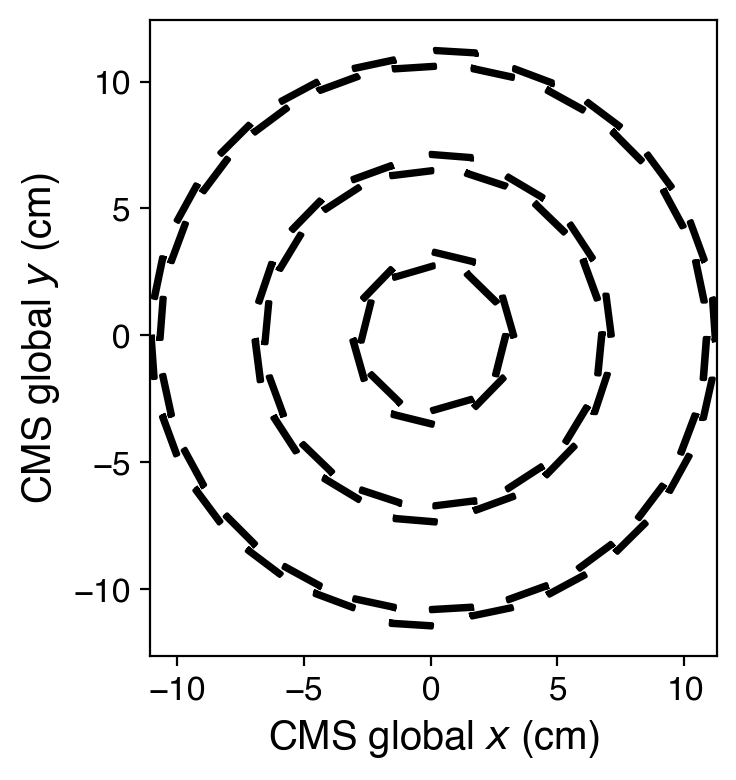

In [146]:
fig, ax = plt.subplots(figsize=(4,4))
utils.plot_overlay_bpix(ax=ax)

ax.set_aspect(1.)

ax.set_xlabel("CMS global $x$ (cm)")
ax.set_ylabel("CMS global $y$ (cm)")

fig.set_tight_layout(True)
fig.savefig("pixel_geometry.pdf")
!pwd

### DV selection plots

In [5]:
from dask.distributed import LocalCluster
localcluster = LocalCluster(n_workers=10, threads_per_worker=1, memory_limit="2GB")
localcluster

/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 9124 instead
  warnings.warn(


In [6]:
client = Client(localcluster)
client

Client Scheduler: tcp://127.0.0.1:24379 Dashboard: http://127.0.0.1:9124/status,Cluster Workers: 1 Cores: 1 Memory: 2.00 GB


In [7]:
fnames = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run201*skim_201*_v12_RAW_dvnm1/*.root")
len(fnames)

328

In [8]:
chunks, total_events = utils.get_chunking(tuple(fnames), 1e6)

len(chunks), total_events

(814, 638490212)

<AxesSubplot:>

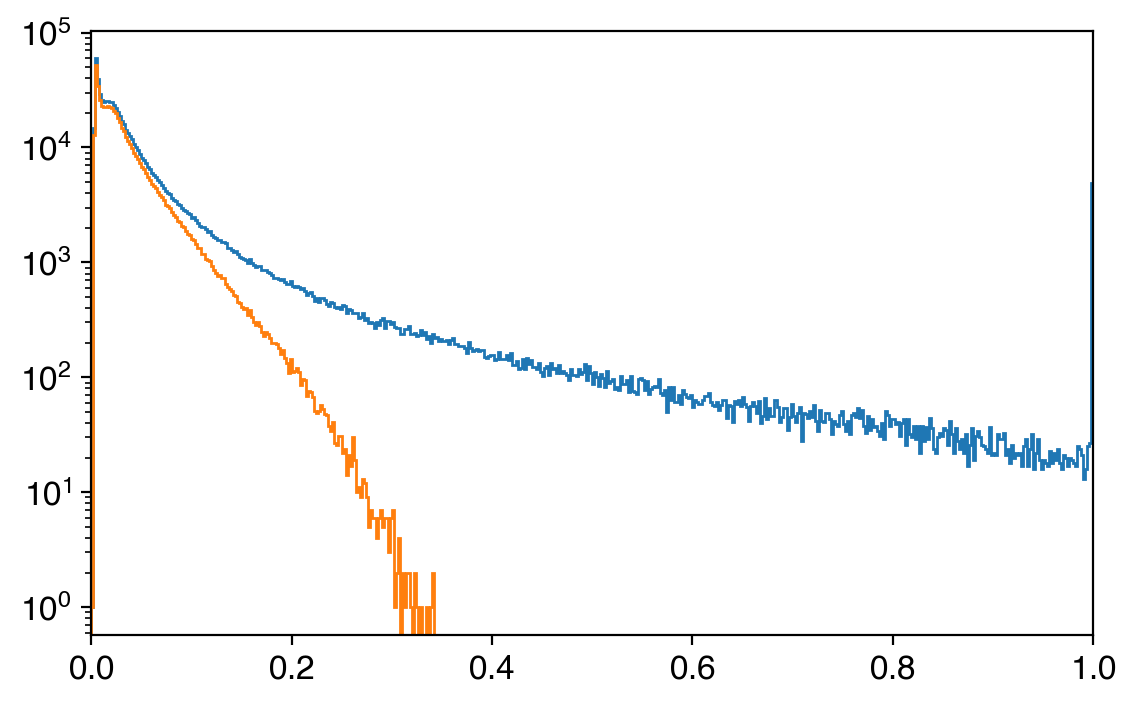

In [23]:
def get_hists(fname, entrystart=None, entrystop=None):
    t = uproot.open(fname)["Events"]
    branches = ["DV_rhoCorr", "DV_xError", "DV_yError", "DV_zError", "DV_chi2", "DV_ndof", "pass_l1"]
    arrs = t.arrays(
        branches,
        outputtype = dict,
        namedecode = "ascii",
        entrystart = entrystart,
        entrystop = entrystop,
    )
    df = pd.DataFrame(arrs)
    df = df[df["pass_l1"]]
    df = df.assign(**{"DV_chi2ndof": (lambda x: x.eval("DV_chi2/DV_ndof"))}).drop(["DV_chi2","DV_ndof","pass_l1"], axis=1)
    d_hists = {
        "lxy_inc": Hist1D(df["DV_rhoCorr"], bins="1000,0,50"),
        "xError_inc": Hist1D(df["DV_xError"], bins="500,0,0.5"),
        "yError_inc": Hist1D(df["DV_yError"], bins="500,0,0.5"),
        "zError_inc": Hist1D(df["DV_zError"], bins="500,0,1"),
        "chi2ndof_inc": Hist1D(df["DV_chi2ndof"], bins="500,0,10"),
        "lxy_nm1": Hist1D(df[df.eval("DV_xError<0.05 and DV_yError<0.05 and DV_zError<0.10 and DV_chi2ndof<5")]["DV_rhoCorr"], bins="1000,0,50"),
        "xError_nm1": Hist1D(df[df.eval("DV_yError<0.05 and DV_zError<0.10 and DV_chi2ndof<5 and DV_rhoCorr<11.")]["DV_xError"], bins="500,0,0.5"),
        "yError_nm1": Hist1D(df[df.eval("DV_xError<0.05 and DV_zError<0.10 and DV_chi2ndof<5 and DV_rhoCorr<11.")]["DV_yError"], bins="500,0,0.5"),
        "zError_nm1": Hist1D(df[df.eval("DV_xError<0.05 and DV_yError<0.05 and DV_chi2ndof<5 and DV_rhoCorr<11.")]["DV_zError"], bins="500,0,1"),
        "chi2ndof_nm1": Hist1D(df[df.eval("DV_xError<0.05 and DV_yError<0.05 and DV_zError<0.10 and DV_rhoCorr<11.")]["DV_chi2ndof"], bins="500,0,10"),
    }
    return d_hists
    
d_hists = get_hists(*chunks[0])

d_hists["zError_inc"].plot(histtype="step", log=True)
d_hists["zError_nm1"].plot(histtype="step", log=True)

In [24]:
import dask
from collections import defaultdict
import dask.distributed as distributed
import time

all_hists = [delayed(get_hists, pure=True)(fname) for fname in fnames]
client.persist(all_hists)
futures = client.compute(all_hists)
tot_results = defaultdict(int)
for future in tqdm(distributed.as_completed(futures), total=len(futures)):
    d = future.result()
    for k,v in d.items():
        tot_results[k] += v

In [25]:
mchists = get_hists("../batch/dvnm1/output_mzd8_ctau10mm.root")

In [30]:
!mkdir -p plots_selection_dv

for varexp in ["lxy","xError","yError","zError","chi2ndof"]:
    for which in ["inc", "nm1"]:
        log = True

        h_data = tot_results[f"{varexp}_{which}"]
        h_mc = mchists[f"{varexp}_{which}"]

        h_mc *= h_data.integral / h_mc.integral

        fig, ax = plt.subplots()

        h_data.plot(histtype="step", log=log, label="Data", color="k")
        h_mc.plot(histtype="step", log=log, label=r"H$\rightarrow \mathrm{Z_d Z_d}$ (8GeV,c$\tau$=10mm)", color="C3")

        if not log:
            ax.set_ylim(bottom=0.)

        add_cms_info_1d(ax)
        ax.set_ylabel("Events", horizontalalignment="right",y=1.)
        xlabel = {
            "lxy": r"$l_\mathrm{xy}$ (cm)",
            "xError": r"DV x Error (cm)",
            "yError": r"DV y Error (cm)",
            "zError": r"DV z Error (cm)",
            "chi2ndof": r"DV chi2/ndof",
        }[varexp]
        ax.set_xlabel(xlabel, horizontalalignment="right",x=1., labelpad=-1.0)

        fname = f"{varexp}_{which}.pdf"
        print(fname)
        fig.savefig(f"plots_selection_dv/{fname}")
        plt.close()

lxy_inc.pdf
lxy_nm1.pdf
xError_inc.pdf
xError_nm1.pdf
yError_inc.pdf
yError_nm1.pdf
zError_inc.pdf
zError_nm1.pdf
chi2ndof_inc.pdf
chi2ndof_nm1.pdf


### Muon eta horns?

In [5]:
from dask.distributed import LocalCluster
localcluster = LocalCluster(n_workers=10, threads_per_worker=1, memory_limit="6GB")
localcluster

In [6]:
client = Client(localcluster)
client

Client Scheduler: tcp://127.0.0.1:12176 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 10 Memory: 60.00 GB


distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing


Client Scheduler: tcp://127.0.0.1:12176 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 10 Memory: 60.00 GB


In [59]:
fnames_data = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run201*skim_201*_v12_RAW_v24/*.root")
# fname = fnames_data[:100]
# fname = fnames_data[:]
fname = fnames_data[:]
# seeds = ['L1_DoubleMu4p5_SQ_OS_dR_Max1p2','L1_DoubleMu4_SQ_OS_dR_Max1p2','L1_DoubleMu0er1p4_SQ_OS_dR_Max1p4','L1_DoubleMu_15_7']
# branches = seeds+["Muon2_eta","lxy","pass_baseline_iso", "pass_all", "logabsetaphi", "dimuon_mass", "MET_pt","MET_phi"]
# cut = "pass_baseline_iso and lxy<0.2 and dimuon_mass<5"
# branches = ["lxy","dimuon_mass", "logabsetaphi","pass_all"]
# cut = "pass_all and lxy>1 and dimuon_mass>5"
branches = ["Muon2_eta", "lxy", "pass_all", "pass_baseline_iso", "dimuon_mass"]
branches += [
#     "logabsetaphi",
    "DV_zError",
#     "Muon2_trackIso",
    "Muon2_nValidMuonHits",
    "Muon2_phi",
    "nJet",
    "year",
    "MET_pt",
    "rho",
    "MET_phi",
    "Muon2_dxy",
    "Muon2_dz",
#     "Muon2_chi2",
]
cut = "pass_all and lxy<0.2"
# cut = "pass_baseline_iso and lxy<0.2"
df_data = make_df(fname, branches=branches, cut=cut, use_dask=True, client=client, xrootd=True)

In [60]:
from dask.distributed import progress
progress(df_data)

VBox()

In [61]:
df = df_data.compute()
print((df.memory_usage()*1e-6).sum())

152.205312


In [62]:
df

,Muon2_eta,lxy,pass_all,pass_baseline_iso,dimuon_mass,DV_zError,Muon2_nValidMuonHits,Muon2_phi,nJet,year,MET_pt,rho,MET_phi,Muon2_dxy,Muon2_dz
0,1.387837,0.174900,True,True,1.848771,0.029535,0,-3.053059,0,2017,7.367891,10.125254,2.158783,-0.010410,0.567316
1,1.583038,0.055133,True,True,2.050170,0.039604,0,0.839378,0,2017,25.813412,12.408450,-2.956579,-0.095299,-3.619245
2,2.275006,0.064812,True,True,2.988843,0.064512,0,2.219769,0,2017,19.947994,7.229088,-2.226523,-0.064004,-1.040376
3,1.007770,0.068549,True,True,3.074903,0.018330,0,-2.183059,0,2017,19.770132,6.960019,2.718228,0.075921,2.292467
4,0.279019,0.071603,True,True,3.068409,0.005977,0,3.037035,0,2017,23.427580,10.733378,1.471815,0.010260,-2.259837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,2.156049,0.045522,True,True,3.607755,0.029073,23,2.247016,0,2018,17.606955,12.392503,3.107925,-0.022592,3.899673
97,1.395679,0.101886,True,True,3.106946,0.017899,16,-2.413830,0,2018,12.461005,14.914083,-0.725537,0.083868,1.340719
98,0.892286,0.073077,True,True,2.819748,0.011667,18,0.102480,0,2018,7.269384,9.531447,0.898493,-0.084821,2.146939
99,1.491547,0.148931,True,True,3.065516,0.030448,45,0.158257,0,2018,40.240528,12.551123,-2.856439,-0.034187,-0.518144


Text(0.5, 1.0, 'Muon2_eta [passing all selections, lxy<0.2cm]')

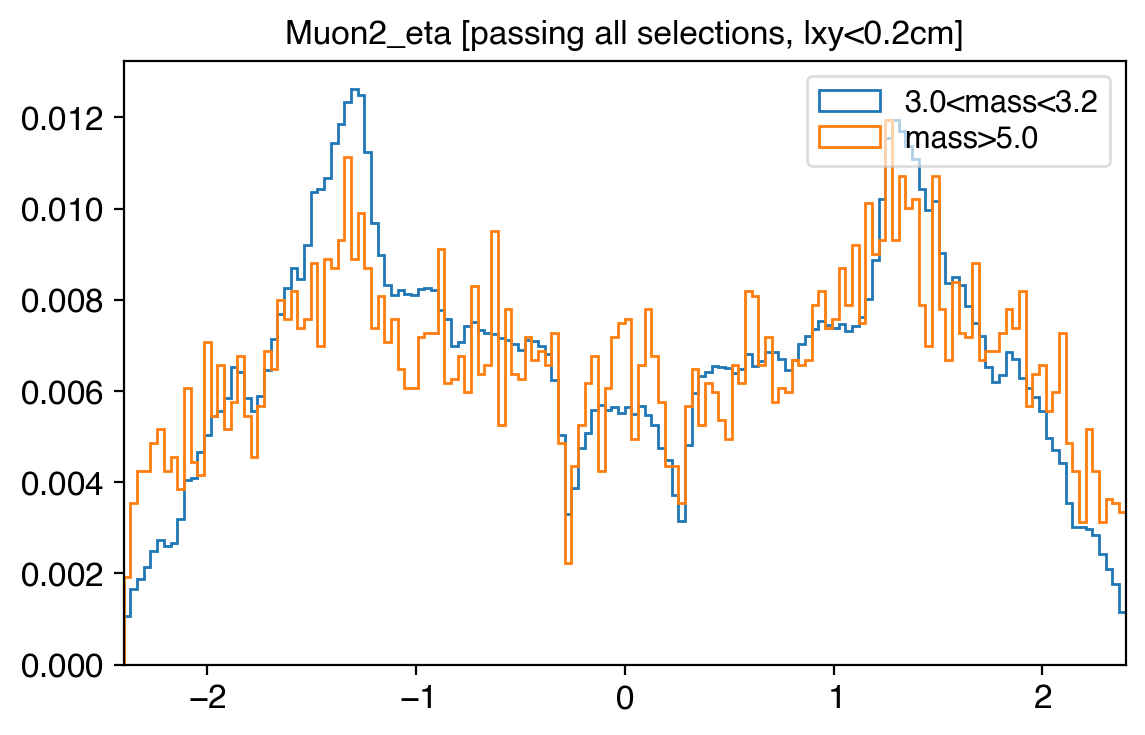

In [63]:
fig, ax = plt.subplots()

bins = "150,-2.4,2.4"
# Hist1D(df["Muon2_eta"], bins=bins).plot(histtype="step", label="all")
Hist1D(df["Muon2_eta"][df.eval("3.0<dimuon_mass<3.2")], bins=bins).normalize().plot(histtype="step", label="3.0<mass<3.2")
Hist1D(df["Muon2_eta"][df.eval("5.0<dimuon_mass")], bins=bins).normalize().plot(histtype="step", label="mass>5.0")

ax.set_title("Muon2_eta [passing all selections, lxy<0.2cm]")

### Cutflow

In [7]:
cutflow_strings = [
    "(pass_l1 and dimuon_isos)",
    "(Muon1_passid and Muon2_passid)",
    "(Muon1_passiso and Muon2_passiso)",
    "(absdphimumu<2.8)",
    "(absdphimudv<0.02)",
    "pass_excesshits",
    "pass_materialveto",
    "(logabsetaphi<1.25)",
    "pass_dxysig",
    "pass_dxyscaled",
]
d_cutflow_labels = {
    "(pass_l1 and dimuon_isos)": "Trigger, DV + 2 OS muons",
    "(Muon1_passid and Muon2_passid)": "Muon ID",
    "(Muon1_passiso and Muon2_passiso)": "Muon Iso.",
    "(absdphimumu<2.8)": r"$\dphimumu<2.8$",
    "(absdphimudv<0.02)": r"$\dphimudv<0.02$",
    "pass_excesshits": "Excess hit veto",
    "pass_materialveto": "Material veto",
    "(logabsetaphi<1.25)": "$\logabsetaphi<1.25$",
    "pass_dxysig": r"$\dxy/\sigmadxy>2$",
    "pass_dxyscaled": r"$\scaleddxy>0.1$",
    "pass_all": r"pass all",
}
def get_cutflow_one(fname, isdata=True):
    t = uproot.open(fname)["Events"]
    df = t.pandas.df(["pass_l1", "Muon1_passid", "Muon2_passid", "Muon1_passiso", "Muon2_passiso", "absdphimumu", "absdphimudv", "dimuon_isos", "lxy", "pass_excesshits", "logabsetaphi", "pass_materialveto", "pass_dxyscaled", "pass_dxysig", "dimuon_mass"])
    categories = ["dimuon_mass<5", "dimuon_mass>5", "dimuon_mass<5 and lxy>1", "dimuon_mass>5 and lxy>1"]
    if not isdata:
        categories += ["dimuon_mass>0", "lxy<1", "lxy>1"]
    results = dict()
    curr_cuts = []
    for step in cutflow_strings:
        curr_cuts.append(step)
        cut = " and ".join(curr_cuts)
        for categ in categories:
            results[(step, categ)] = df.eval(cut + f" and ({categ})").sum()
    return results

fname = fnames_data[0]
get_cutflow_one(fname)

{('(pass_l1 and dimuon_isos)', 'dimuon_mass<5'): 1159001,
 ('(pass_l1 and dimuon_isos)', 'dimuon_mass>5'): 190498,
 ('(pass_l1 and dimuon_isos)', 'dimuon_mass<5 and lxy>1'): 11367,
 ('(pass_l1 and dimuon_isos)', 'dimuon_mass>5 and lxy>1'): 354,
 ('(Muon1_passid and Muon2_passid)', 'dimuon_mass<5'): 1128886,
 ('(Muon1_passid and Muon2_passid)', 'dimuon_mass>5'): 185085,
 ('(Muon1_passid and Muon2_passid)', 'dimuon_mass<5 and lxy>1'): 11018,
 ('(Muon1_passid and Muon2_passid)', 'dimuon_mass>5 and lxy>1'): 303,
 ('(Muon1_passiso and Muon2_passiso)', 'dimuon_mass<5'): 404374,
 ('(Muon1_passiso and Muon2_passiso)', 'dimuon_mass>5'): 66700,
 ('(Muon1_passiso and Muon2_passiso)', 'dimuon_mass<5 and lxy>1'): 2981,
 ('(Muon1_passiso and Muon2_passiso)', 'dimuon_mass>5 and lxy>1'): 129,
 ('(absdphimumu<2.8)', 'dimuon_mass<5'): 404374,
 ('(absdphimumu<2.8)', 'dimuon_mass>5'): 46350,
 ('(absdphimumu<2.8)', 'dimuon_mass<5 and lxy>1'): 2981,
 ('(absdphimumu<2.8)', 'dimuon_mass>5 and lxy>1'): 96,
 ('

In [29]:
import dask
from collections import defaultdict
import dask.distributed as distributed
import time
def get_cutflow_data(fnames_data):
    cutflows = [delayed(get_cutflow_one, pure=True)(fname) for fname in fnames_data]
    client.persist(cutflows, isdata=True)
    futures = client.compute(cutflows)
    tot_results = defaultdict(int)
    for future in tqdm(distributed.as_completed(futures), total=len(futures)):
        d = future.result()
        for k,v in d.items():
            tot_results[k] += v
    return tot_results

In [30]:
cutflow_data = get_cutflow_data(fnames_data)
cutflow_data

defaultdict(int,
            {('(pass_l1 and dimuon_isos)', 'dimuon_mass<5'): 284002929,
             ('(pass_l1 and dimuon_isos)', 'dimuon_mass>5'): 46424428,
             ('(pass_l1 and dimuon_isos)', 'dimuon_mass<5 and lxy>1'): 3304466,
             ('(pass_l1 and dimuon_isos)', 'dimuon_mass>5 and lxy>1'): 108375,
             ('(Muon1_passid and Muon2_passid)', 'dimuon_mass<5'): 274045672,
             ('(Muon1_passid and Muon2_passid)', 'dimuon_mass>5'): 44816219,
             ('(Muon1_passid and Muon2_passid)',
              'dimuon_mass<5 and lxy>1'): 3146897,
             ('(Muon1_passid and Muon2_passid)',
              'dimuon_mass>5 and lxy>1'): 91186,
             ('(Muon1_passiso and Muon2_passiso)', 'dimuon_mass<5'): 101592165,
             ('(Muon1_passiso and Muon2_passiso)', 'dimuon_mass>5'): 17745365,
             ('(Muon1_passiso and Muon2_passiso)',
              'dimuon_mass<5 and lxy>1'): 840381,
             ('(Muon1_passiso and Muon2_passiso)',
              'di

In [31]:

cutflow_mcs = [
    dict(key=("hzd",2,1),label=r"H$\rightarrow \mathrm{Z_d Z_d}$ (2 GeV, c$\tau$=1 mm)"),
    dict(key=("hzd",2,10),label=r"H$\rightarrow \mathrm{Z_d Z_d}$ (2 GeV, c$\tau$=10 mm)"),
    dict(key=("hzd",8,100),label=r"H$\rightarrow \mathrm{Z_d Z_d}$ (8 GeV, c$\tau$=100 mm)"),
]

for i in range(len(cutflow_mcs)):
    model, mass, ctau = cutflow_mcs[i]["key"]
    smodel = {"bphi":"BToPhi","hzd":"HToZdZd"}[model]
    particle = {"bphi":"mphi","hzd":"mzd"}[model]
    smass = str(mass).replace(".0","").replace(".","p")
    fpatt = f"/hadoop/cms/store/user/namin/ProjectMetis/{smodel}*_*{particle}{smass}_ctau{ctau}mm_BABY_vtestfine2/*.root"
    fnames = glob.glob(fpatt)
    tot_results = defaultdict(int)
    for fname in tqdm(fnames):
        d = get_cutflow_one(fname, isdata=False)
        for k,v in d.items():
            tot_results[k] += v
    cutflow_mcs[i]["cutflow"] = tot_results

In [32]:

buff = ""
buff += "\\begin{tabular}{l|c|c|c|c|c|c|c|c|c|c}"
buff += "\\hline \n"
buff += r" & \multicolumn{2}{c|}{Data ($<5\GeV$)} & \multicolumn{2}{c|}{Data ($>5\GeV$)}"
for i,item in enumerate(cutflow_mcs):
    if i == 2:
        buff += r" & \multicolumn{2}{c}{"+item["label"]+"}"
    else:
        buff += r" & \multicolumn{2}{c|}{"+item["label"]+"}"
buff += "\\\\ \n"
buff += "Selection " + r" & $\lxy<1\unit{cm}$ & $\lxy>1\unit{cm}$ "*5 + "\\\\ \n"
buff += "\\hline \n"
for cut in cutflow_strings:
    nums = []
    nums.append(cutflow_data[(cut, "dimuon_mass<5")]-cutflow_data[(cut, "dimuon_mass<5 and lxy>1")])
    nums.append(cutflow_data[(cut, "dimuon_mass<5 and lxy>1")])
    nums.append(cutflow_data[(cut, "dimuon_mass>5")]-cutflow_data[(cut, "dimuon_mass>5 and lxy>1")])
    nums.append(cutflow_data[(cut, "dimuon_mass>5 and lxy>1")])
    for item in cutflow_mcs:
        cutflow = item["cutflow"]
        nums.append(cutflow[(cut, "lxy<1")])
        nums.append(cutflow[(cut, "lxy>1")])
    buff += d_cutflow_labels[cut] + " & " + " & ".join(map(str, nums)) + " \\\\ \n"
buff += "\\hline \n"
buff += "\\end{tabular}"

print(buff)

\begin{tabular}{l|c|c|c|c|c|c|c|c|c|c}\hline 
 & \multicolumn{2}{c|}{Data ($<5\GeV$)} & \multicolumn{2}{c|}{Data ($>5\GeV$)} & \multicolumn{2}{c|}{H$\rightarrow \mathrm{Z_d Z_d}$ (2 GeV, c$\tau$=1 mm)} & \multicolumn{2}{c|}{H$\rightarrow \mathrm{Z_d Z_d}$ (2 GeV, c$\tau$=10 mm)} & \multicolumn{2}{c}{H$\rightarrow \mathrm{Z_d Z_d}$ (8 GeV, c$\tau$=100 mm)}\\ 
Selection  & $\lxy<1\unit{cm}$ & $\lxy>1\unit{cm}$  & $\lxy<1\unit{cm}$ & $\lxy>1\unit{cm}$  & $\lxy<1\unit{cm}$ & $\lxy>1\unit{cm}$  & $\lxy<1\unit{cm}$ & $\lxy>1\unit{cm}$  & $\lxy<1\unit{cm}$ & $\lxy>1\unit{cm}$ \\ 
\hline 
Trigger, DV + 2 OS muons & 280698463 & 3304466 & 46316053 & 108375 & 44301 & 73114 & 5509 & 28226 & 167 & 1042 \\ 
Muon ID & 270898775 & 3146897 & 44725033 & 91186 & 43933 & 72649 & 5466 & 28062 & 164 & 1040 \\ 
Muon Iso. & 100751784 & 840381 & 17704663 & 40702 & 37293 & 66169 & 4594 & 26064 & 148 & 1003 \\ 
$\dphimumu<2.8$ & 100751784 & 840381 & 12110510 & 30093 & 37062 & 66166 & 4581 & 26063 & 148 & 1003 \\